# Import packages 


In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
import pandas as pd
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Using TensorFlow backend.


# Load the data

In [3]:
# load dataset
df=pd.read_csv('/Users/yingyuxuan/Desktop/projects/covid19-global-forecasting-week-5/data/new_df.csv').drop(columns='Unnamed: 0')
# obtian fatality cases data 
confirm=df[df.Target=='ConfirmedCases'].drop(columns='Target')
confirm.head()

,Country_Region,Date,month,day,Population,Weight,TargetValue
0,Afghanistan,2020-01-23,1,23,27657145,0.058359,0.0
2,Afghanistan,2020-01-24,1,24,27657145,0.058359,0.0
4,Afghanistan,2020-01-25,1,25,27657145,0.058359,0.0
6,Afghanistan,2020-01-26,1,26,27657145,0.058359,0.0
8,Afghanistan,2020-01-27,1,27,27657145,0.058359,0.0


In [7]:
#top 10 countries by confiremd cases 
top_10_countries=pd.DataFrame(confirm.groupby('Country_Region')['TargetValue'].sum()).sort_values(by='TargetValue',ascending=False).reset_index()

top_10_country_names=top_10_countries.Country_Region[:11]
top_10_country_names


0                 US
1             Brazil
2             Russia
3     United Kingdom
4              Spain
5              Italy
6             France
7            Germany
8             Canada
9              China
10            Turkey
Name: Country_Region, dtype: object

# Data Standardization

In [9]:
# normalized the data 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(confirm.drop(columns=['TargetValue','Country_Region','Date']))
# create datefrane fir scaled data
scaled_df=pd.DataFrame(data=scaled,columns=confirm.drop(columns=['TargetValue','Country_Region','Date']).columns)

In [10]:
confirmed_Cases=confirm.copy()
confirmed_Cases[scaled_df.columns]=np.array(scaled_df)
confirmed_Cases['country']=list(confirmed_Cases.Country_Region)

In [11]:
confirmed_Cases=confirmed_Cases.set_index(['Country_Region','Date'])
confirmed_Cases.head()

month       day  Population  Weight  TargetValue  \
Country_Region Date                                                           
Afghanistan    2020-01-23    0.0  0.733333    0.019815  0.0616          0.0   
               2020-01-24    0.0  0.766667    0.019815  0.0616          0.0   
               2020-01-25    0.0  0.800000    0.019815  0.0616          0.0   
               2020-01-26    0.0  0.833333    0.019815  0.0616          0.0   
               2020-01-27    0.0  0.866667    0.019815  0.0616          0.0   

                               country  
Country_Region Date                     
Afghanistan    2020-01-23  Afghanistan  
               2020-01-24  Afghanistan  
               2020-01-25  Afghanistan  
               2020-01-26  Afghanistan  
               2020-01-27  Afghanistan

#  Train Test Split

In [12]:
# Because this is panel data so I will split each country_Region's data 
def train_test_split(data):
    size=int(len(data)*0.8)
    # for train data will be collected from each country's data which index is from 0-size (80%)
    x_train =data.drop(columns=['TargetValue']).iloc[0:size] 
    # for test data will be collected from each country's  data which index is from size to the end (20%)
    x_test = data.drop(columns=['TargetValue']).iloc[size:]
    y_train=data['TargetValue'].iloc[0:size] 
    y_test=data['TargetValue'].iloc[size:] 
    return x_train, x_test,y_train,y_test

In [13]:
country=list(set(confirmed_Cases.country))
# loop each country_Region and split the data into train and test data 
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(0,len(country)):
    data=confirmed_Cases[confirmed_Cases['country']==country[i]]
    # applied the function I created above
    x_train, x_test,y_train,y_test=train_test_split(data) 
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

In [17]:
X_train[0].head()

month       day  Population    Weight    country
Country_Region Date                                                        
Sri Lanka      2020-01-23    0.0  0.733333    0.015021  0.067035  Sri Lanka
               2020-01-24    0.0  0.766667    0.015021  0.067035  Sri Lanka
               2020-01-25    0.0  0.800000    0.015021  0.067035  Sri Lanka
               2020-01-26    0.0  0.833333    0.015021  0.067035  Sri Lanka
               2020-01-27    0.0  0.866667    0.015021  0.067035  Sri Lanka

In [18]:
Y_train[0].head()

Country_Region  Date      
Sri Lanka       2020-01-23    0.0
                2020-01-24    0.0
                2020-01-25    0.0
                2020-01-26    0.0
                2020-01-27    1.0
Name: TargetValue, dtype: float64

In [23]:
# concatenate each train dataset in X_train list and Y_train list respectively 
X_train=pd.concat(X_train)
Y_train=pd.DataFrame(pd.concat(Y_train))
# concatenate each test dataset in X_test list and Y_test list respectively
X_test=pd.concat(X_test)
Y_test=pd.DataFrame(pd.concat(Y_test))

In [31]:
# double check the train data and test data and our target 
X_train.head()

month       day  Population    Weight    country
Country_Region Date                                                        
Sri Lanka      2020-01-23    0.0  0.733333    0.015021  0.067035  Sri Lanka
               2020-01-24    0.0  0.766667    0.015021  0.067035  Sri Lanka
               2020-01-25    0.0  0.800000    0.015021  0.067035  Sri Lanka
               2020-01-26    0.0  0.833333    0.015021  0.067035  Sri Lanka
               2020-01-27    0.0  0.866667    0.015021  0.067035  Sri Lanka

In [33]:
X_train.shape

(343490, 5)

# Data Preprocessing

In [25]:
# Code Source: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# create the reshape function
def reshape_data(train,test):
    #Frame as supervised learning and drop all time t columns except PM2.5
    reframed_train = series_to_supervised(train, 1, 1)
    reframed_test = series_to_supervised(test, 1, 1)
    # split into train and test sets
    train= reframed_train.values
    test=reframed_test.values
    # split into input and outputs
    train_X, y_train = train[:, :-1], train[:, -1]
    test_X, y_test = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train,y_test


In [26]:
encoder = LabelEncoder()
#combine X train and Y train as train data 
train_data=pd.DataFrame()
train_data[X_train.columns]=X_train
train_data[Y_train.columns]=Y_train
train_data['country']= encoder.fit_transform(train_data['country'])
#combine X test and Y test as test data 
test_data=pd.DataFrame()
test_data[X_test.columns]=X_test
test_data[Y_test.columns]=Y_test
test_data['country']= encoder.fit_transform(test_data['country'])

In [27]:
# using the function to obtian reshaped x_train,x_test,y_train,y_test
x_train,x_test,y_train,y_test=reshape_data(train_data,test_data)

# Model 
## LSTM for global data

In [34]:
# design network for confirmed cases data 
model = Sequential()
model.add(LSTM(60, activation='relu',input_shape=(x_train.shape[1], x_train.shape[2])))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(x_train, y_train, epochs=30, batch_size=50,  verbose=1, shuffle=False)


Epoch 1/30
343489/343489 [==============================] - 26s 77us/step - loss: 8.5404
Epoch 2/30
343489/343489 [==============================] - 17s 50us/step - loss: 5.8059
Epoch 3/30
343489/343489 [==============================] - 33s 97us/step - loss: 5.7339
Epoch 4/30
343489/343489 [==============================] - 22s 65us/step - loss: 5.7120
Epoch 5/30
343489/343489 [==============================] - 17s 50us/step - loss: 5.7428
Epoch 6/30
343489/343489 [==============================] - 17s 50us/step - loss: 5.7317
Epoch 7/30
343489/343489 [==============================] - 17s 49us/step - loss: 5.6783
Epoch 8/30
343489/343489 [==============================] - 17s 49us/step - loss: 5.6842
Epoch 9/30
343489/343489 [==============================] - 17s 49us/step - loss: 5.6769
Epoch 10/30
343489/343489 [==============================] - 16s 48us/step - loss: 5.6550
Epoch 11/30
343489/343489 [==============================] - 17s 50us/step - loss: 5.6468
Epoch 12/30
343489/

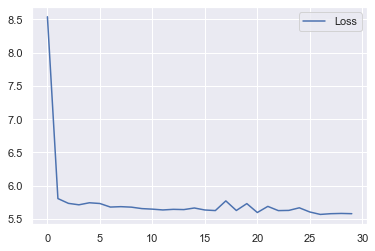

In [35]:
# plot history
plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.show()

## Make prediction

In [36]:
# make a prediction
y_test_pre=model.predict(x_test)
# check length
y_test_pre.shape,y_test.shape

((85921, 1), (85921,))

## Model Evaluation

In [37]:
pa=pd.DataFrame()
pa['Date']=X_test.reset_index().Date.iloc[1:-1]
pa['Prediction']=[i[0] for i in y_test_pre][1:] 
pa['Actual Values']=y_test[:-1]
pa.head()

,Date,Prediction,Actual Values
1,2020-05-02,12.737731,15.0
2,2020-05-03,11.292831,13.0
3,2020-05-04,30.328659,33.0
4,2020-05-05,16.355869,20.0
5,2020-05-06,22.910175,26.0


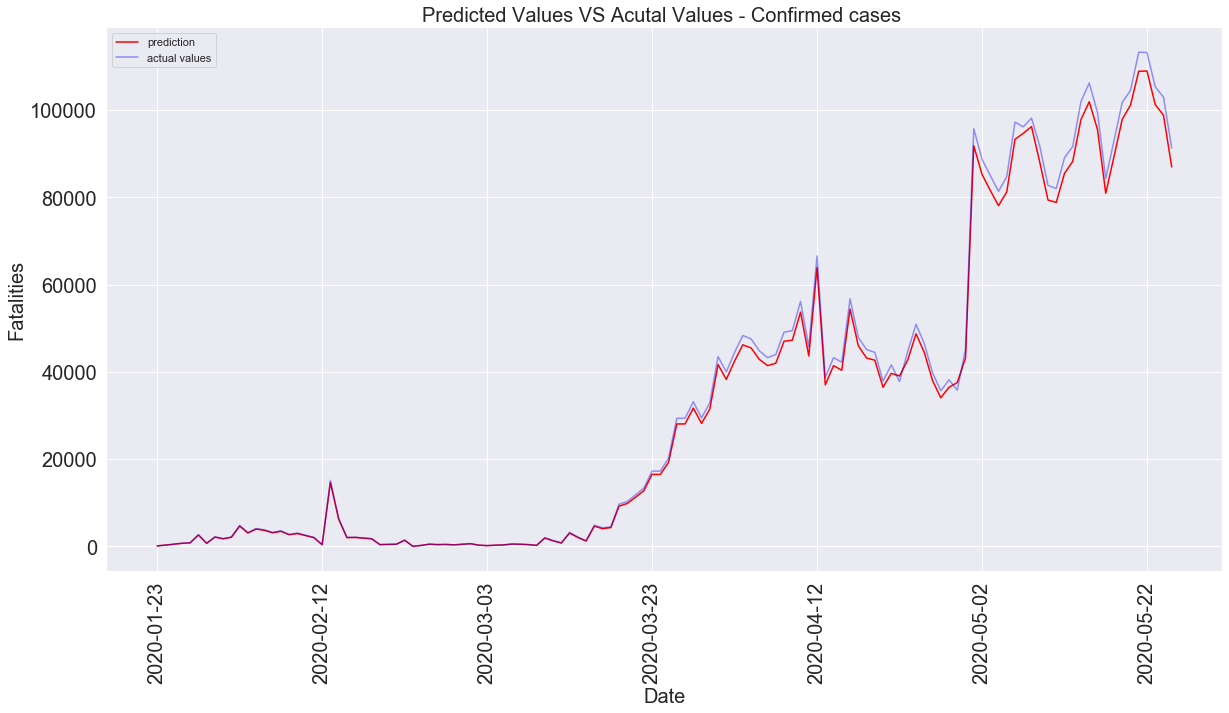

In [38]:
plt.figure(figsize=(20,10))
pa.groupby('Date')['Prediction'].sum().plot(kind='line',label='prediction',color='red',alpha=1)
pa.groupby("Date")['Actual Values'].sum().plot(kind='line',label='actual values',color='blue',alpha=0.4)
plt.xticks(rotation=90,size=20)
plt.yticks(size=20)

plt.ylabel('Fatalities',fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.title('Predicted Values VS Acutal Values - Confirmed cases ',fontsize=20)
plt.legend()

In [302]:
from sklearn.metrics import mean_squared_error
def RMSE(actual,prediction):
    rmse = np.sqrt(mean_squared_error(actual,prediction))
    return rmse

In [303]:
print(RMSE(y_test[:-1],[i[0] for i in y_test_pre][1:]))

66.66583844404396


## LSTM for top 10 contries 

In [217]:
def normalization_train_test_split(country):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(country.drop(columns=['TargetValue','Country_Region','Date']))
    # create datefrane fir scaled data
    scaled_df=pd.DataFrame(data=scaled,columns=country.drop(columns=['TargetValue','Country_Region','Date']).columns)
    scaled_df['TargetValue']=list(country.TargetValue)
    X_train, X_test,Y_train,Y_test=train_test_split(scaled_df)
    #combine x train and y train as train data 
    train_data=pd.DataFrame()
    train_data[X_train.columns]=X_train
    train_data['TargetValues']=Y_train
    #combine x test and y test as test data 
    test_data=pd.DataFrame()
    test_data[X_test.columns]=X_test
    test_data['TargetValues']=Y_test

    # using the function to obtian reshaped x_train,x_test,y_train,y_test
    x_train,x_test,y_train,y_test=reshape_data(train_data,test_data)
    return x_train, x_test,y_train,y_test

US - RMSE: 141.41340542398365
Brazil - RMSE: 1231.65284259092
Russia - RMSE: 280.26593055221053
United Kingdom - RMSE: 1633.3314995403064
Spain - RMSE: 84.21465660565721
Italy - RMSE: 26.619313733890518
France - RMSE: 1674.8059617682995
Germany - RMSE: 39.044871577138935
Canada - RMSE: 39.24356234374055
China - RMSE: 225.31145637034027
Turkey - RMSE: 14.163137113965659


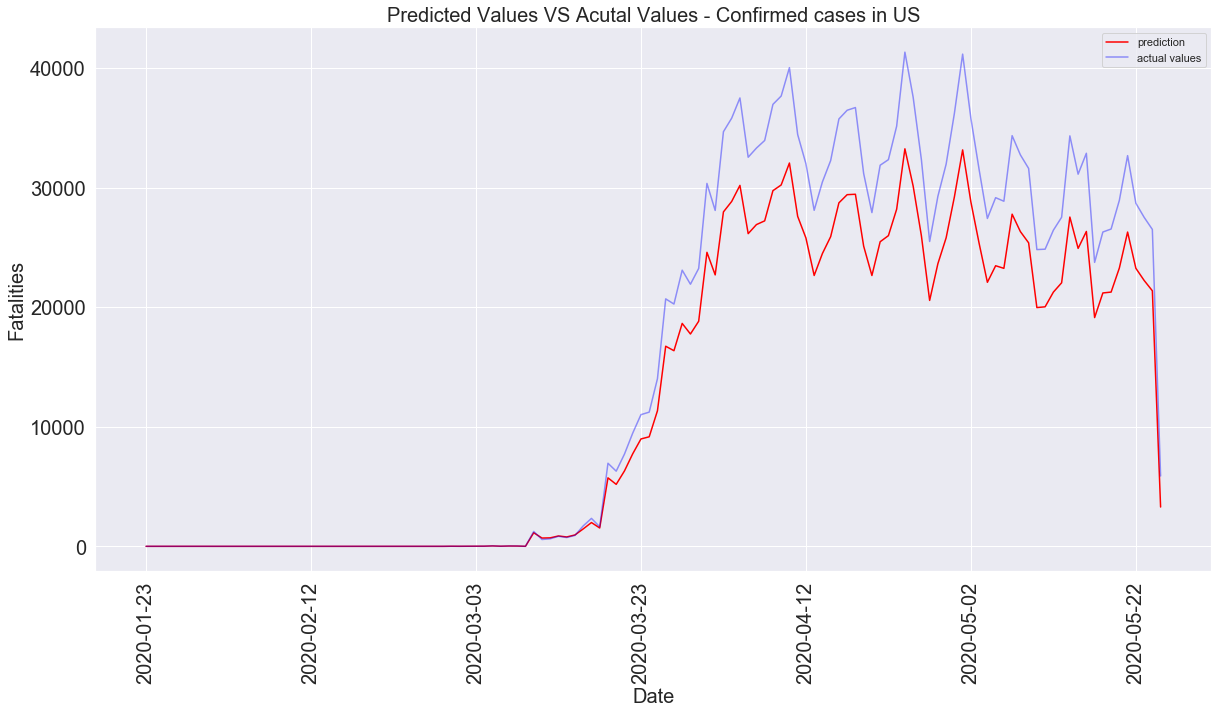

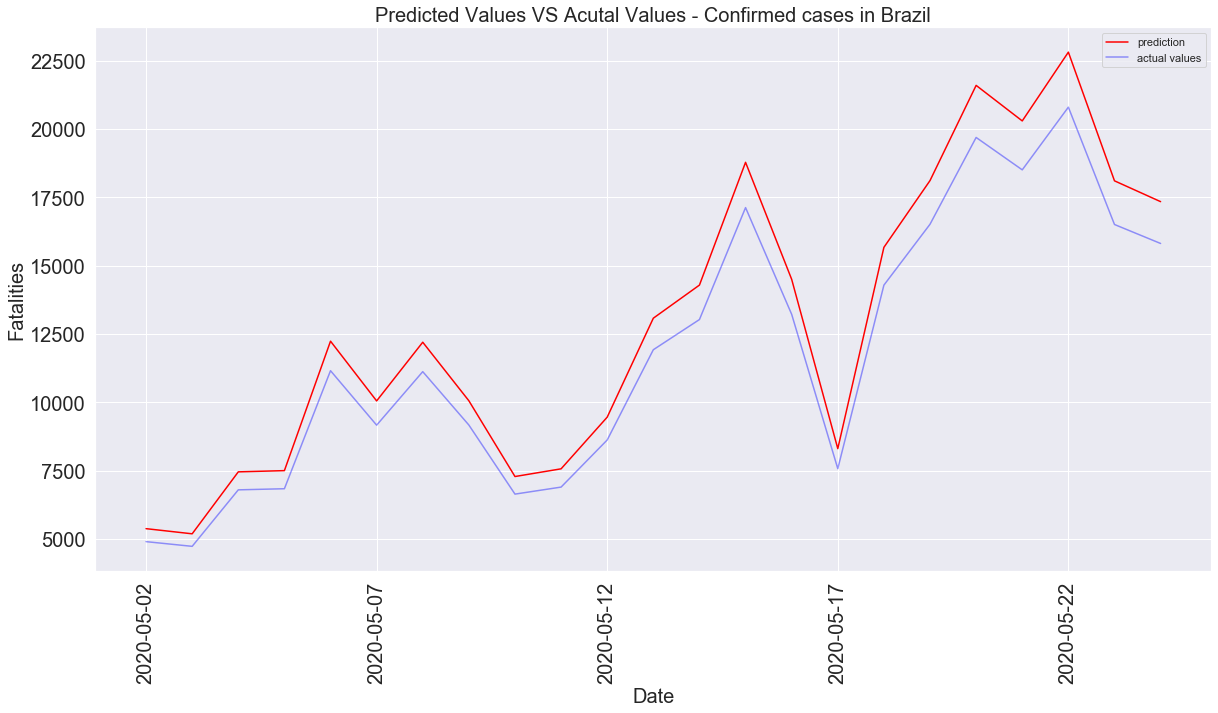

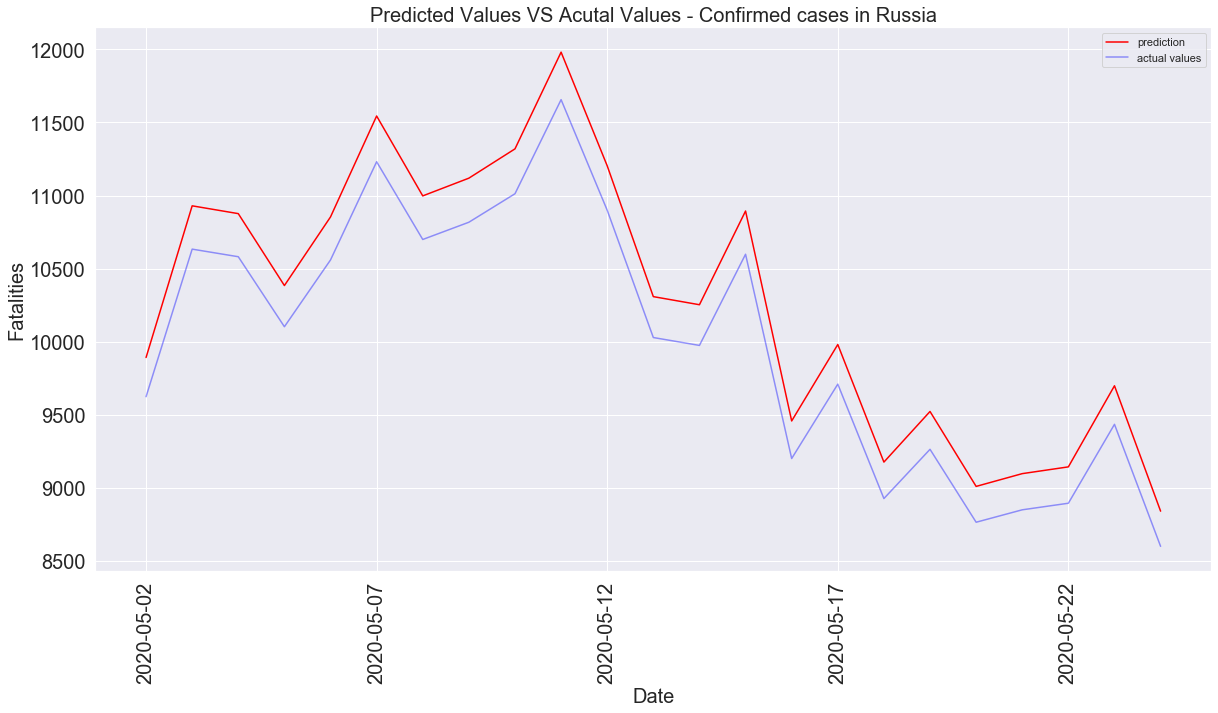

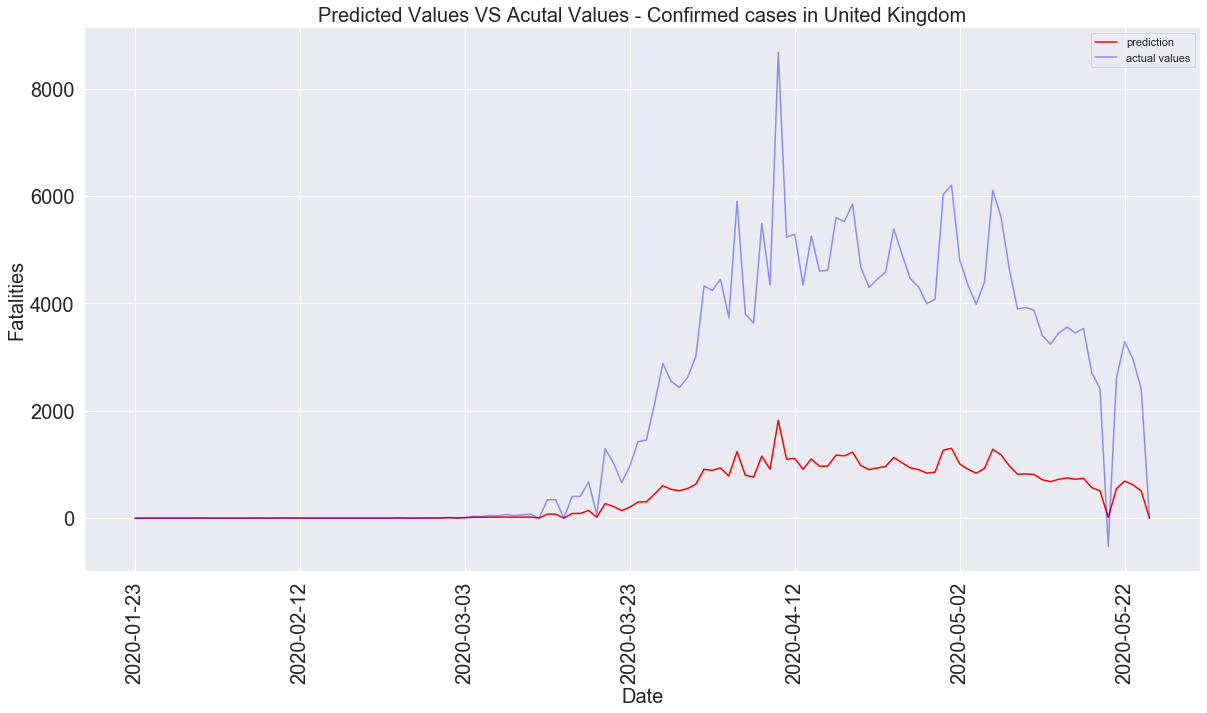

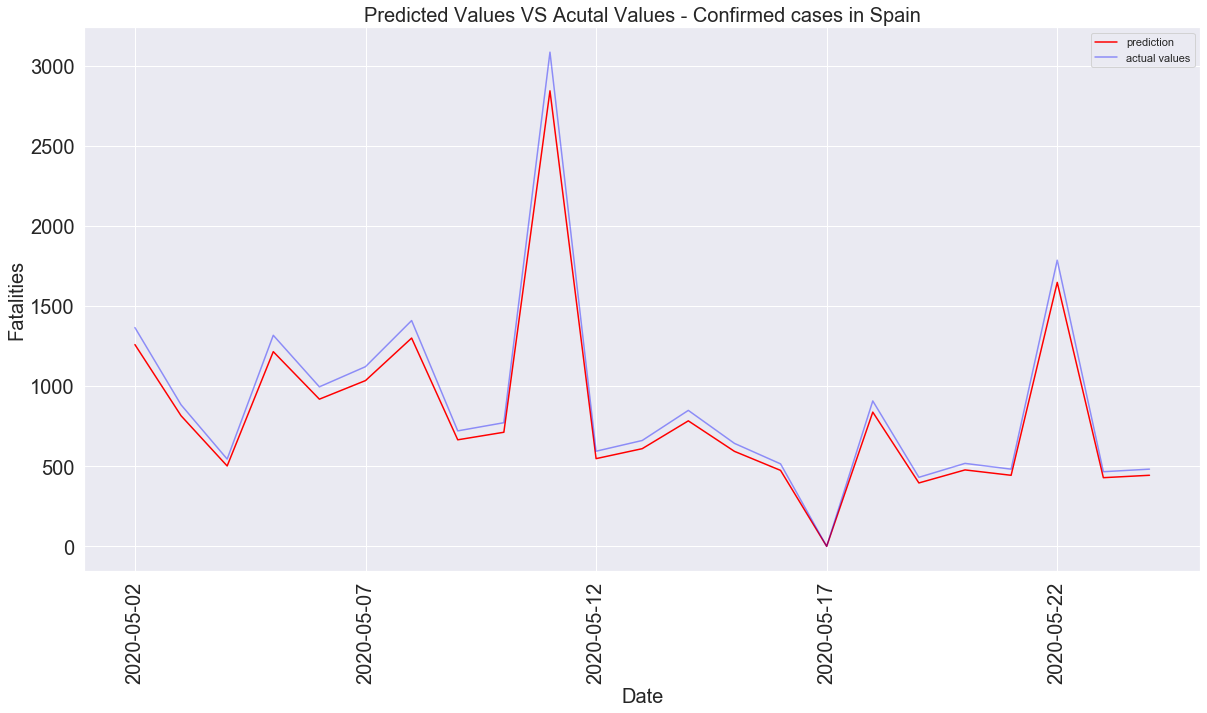

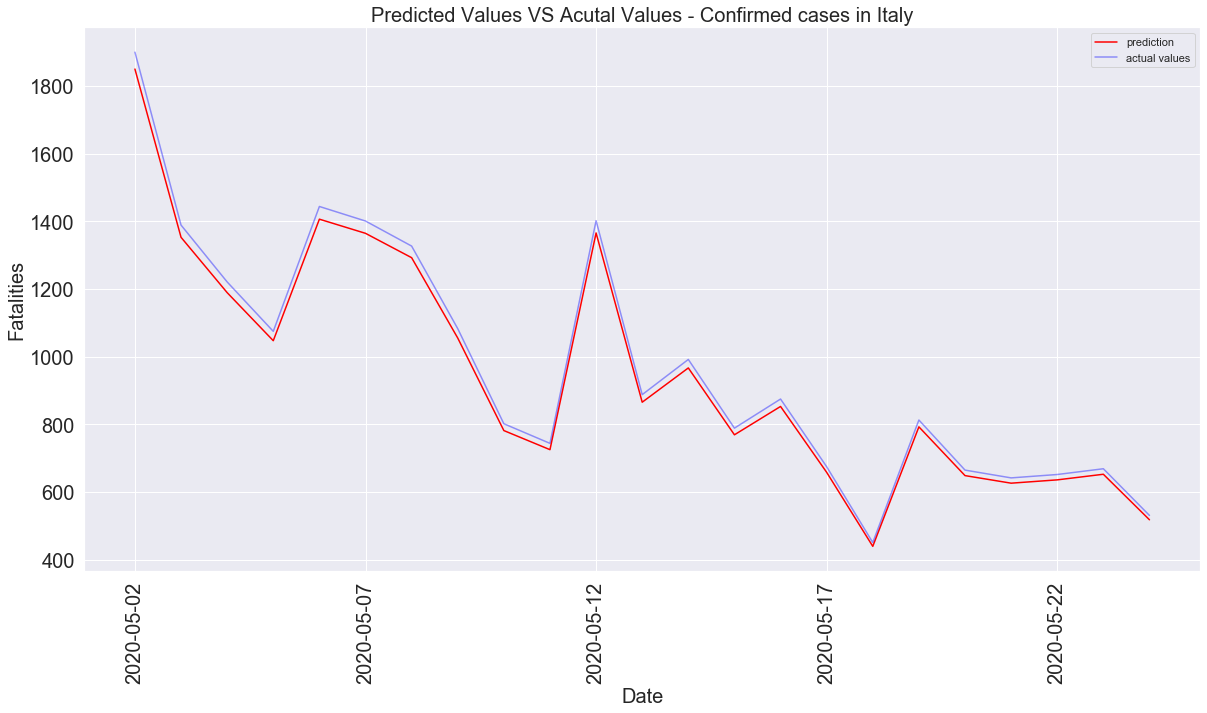

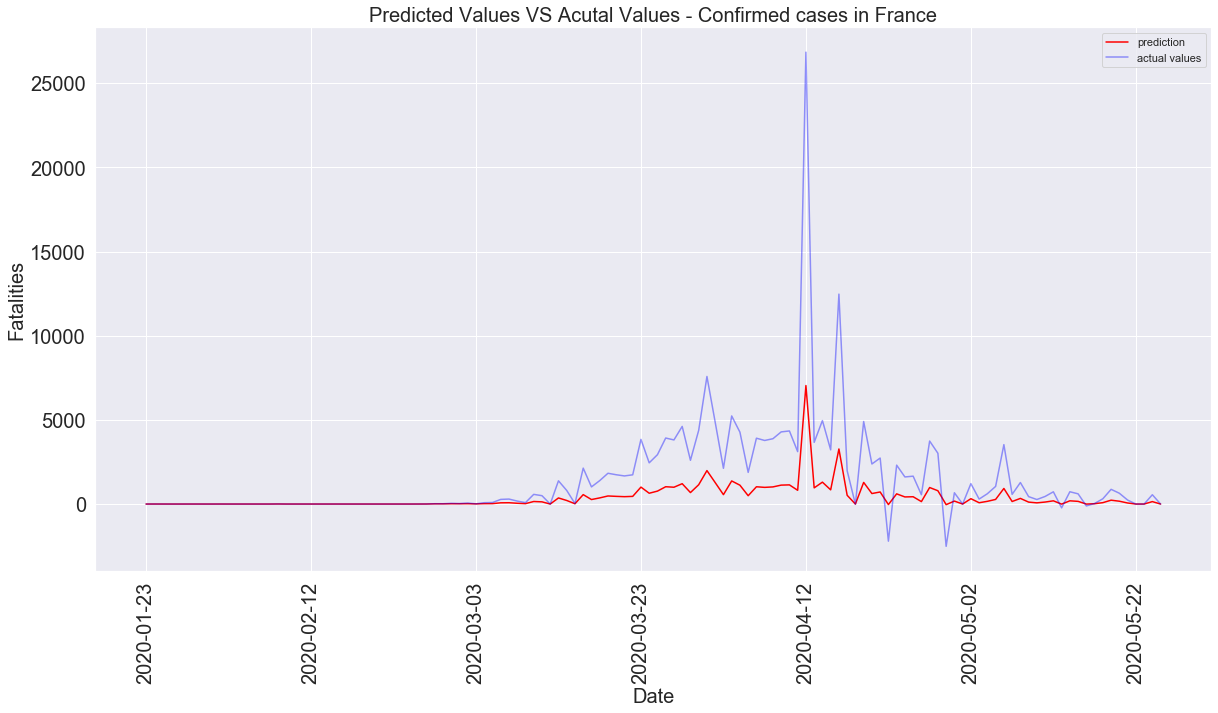

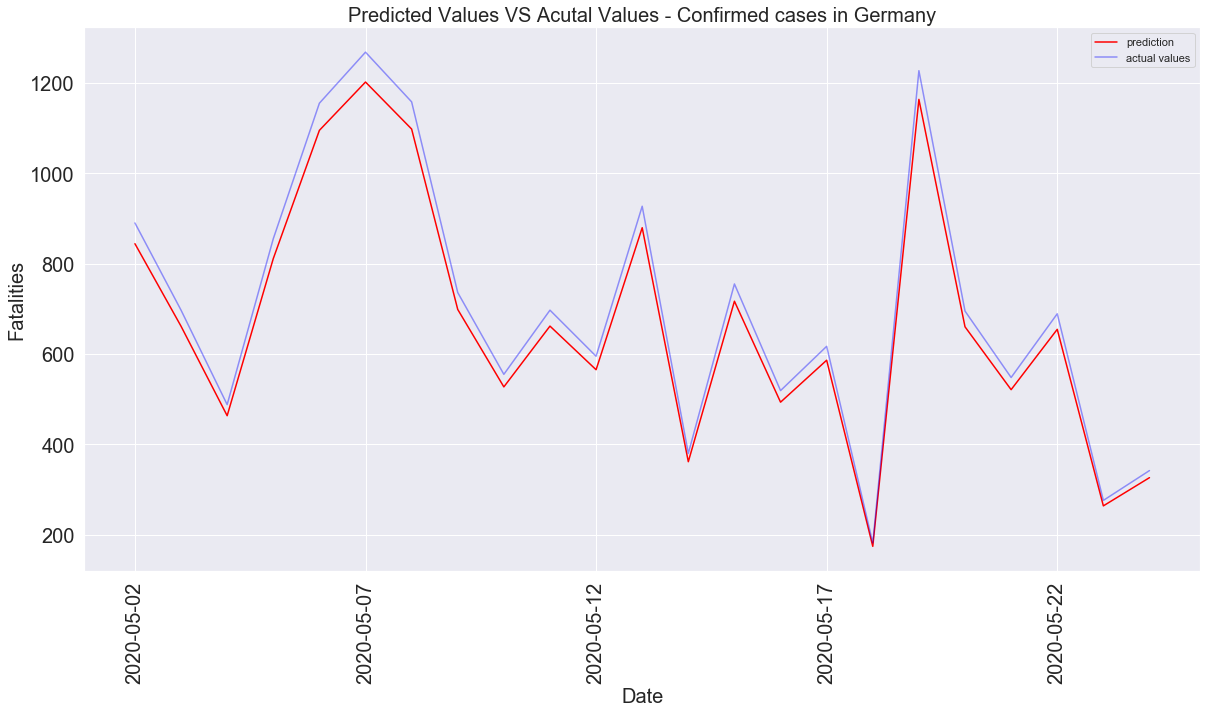

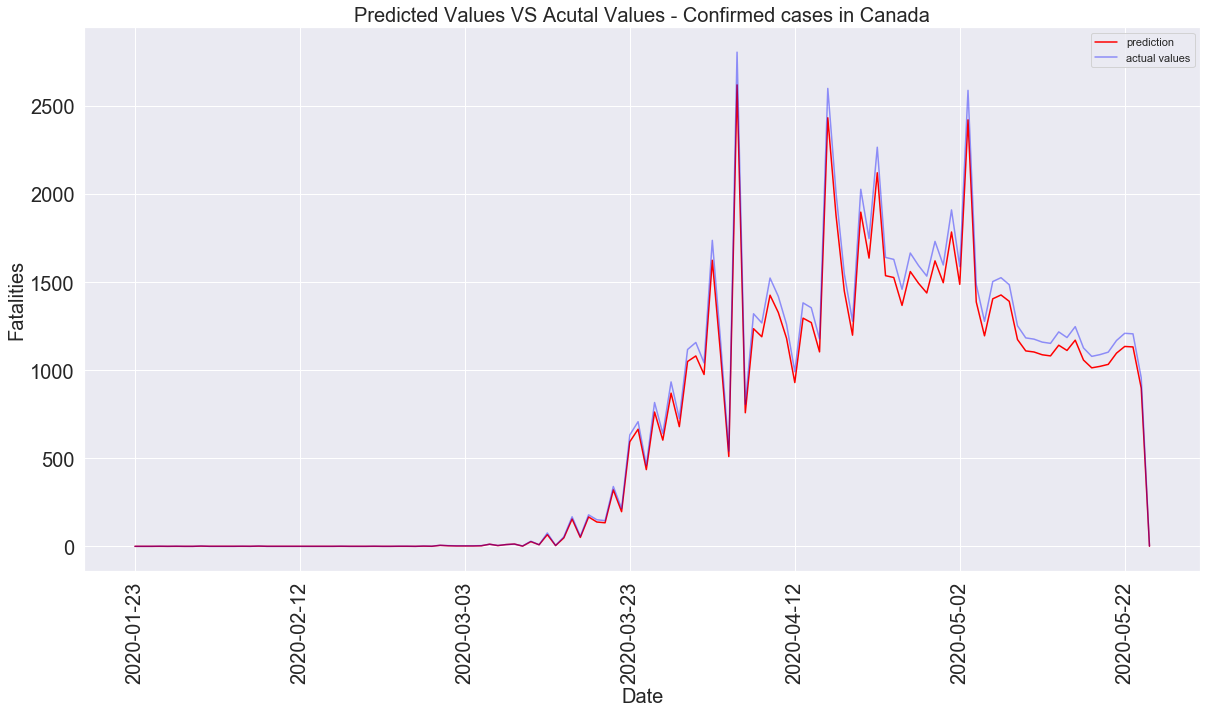

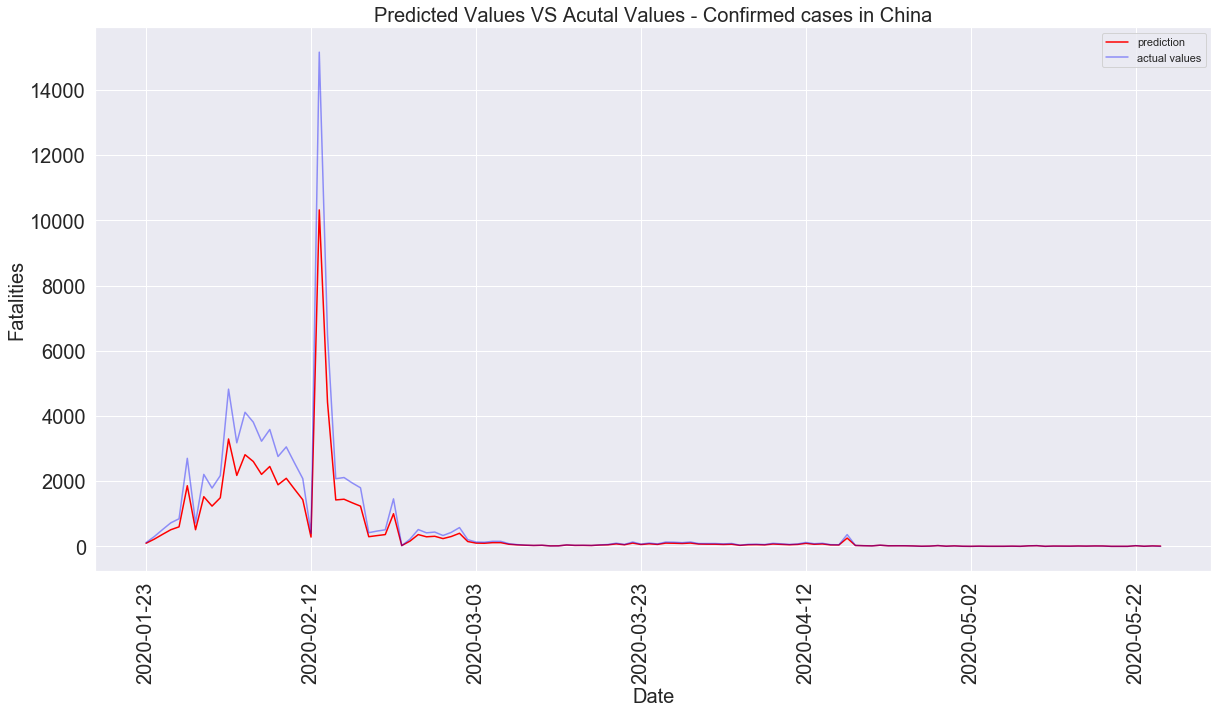

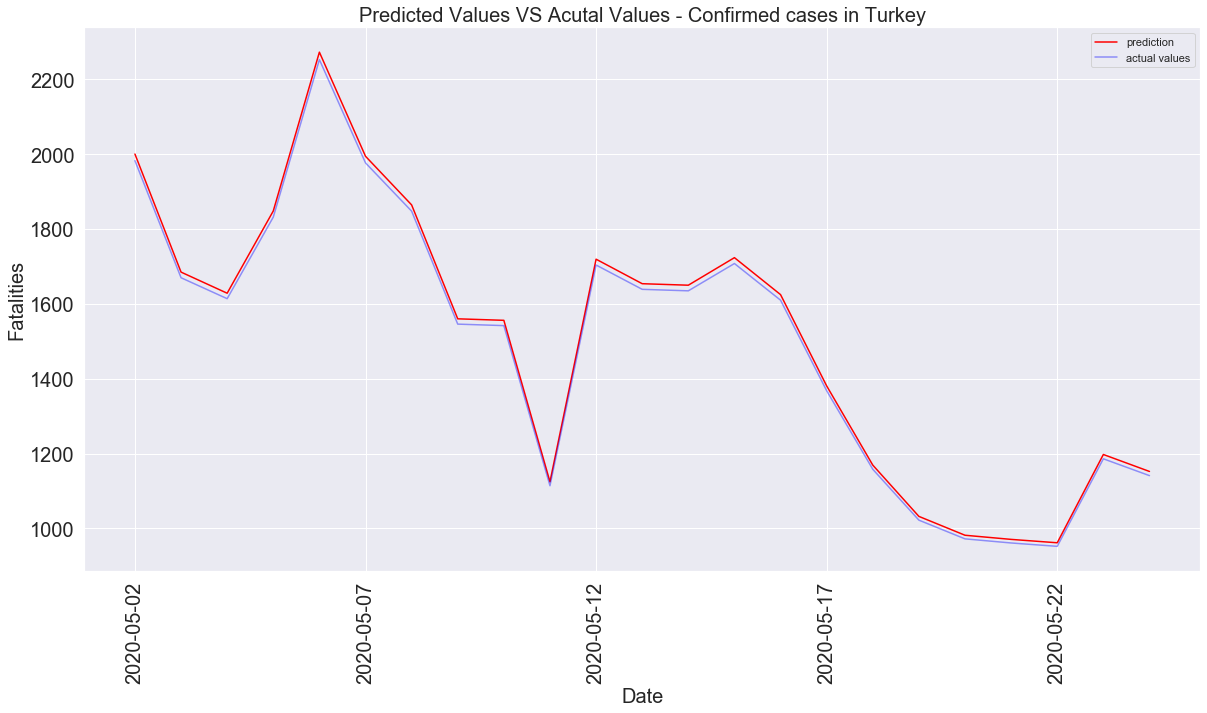

In [273]:
# loop through top 10 countries' data 
# 
for i in range(len(top_10_country_names)): 
     # obtian one country's data 
    country=confirm[confirm.Country_Region==top_10_country_names[i]]
    # train test split, nomalization and reshape the data
    x_train, x_test,y_train,y_test=normalization_train_test_split(country)
    # model 
    model = Sequential()
    model.add(LSTM(60, activation='relu',input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(x_train, y_train, epochs=50, batch_size=30,  verbose=0, shuffle=False)
    # make a prediction
    y_test_pre=model.predict(x_test)
    print('{} - RMSE: {}'.format(top_10_country_names[i],RMSE(y_test[:-1],[i[0] for i in y_test_pre][1:])))
    #create new dataframe for plot 
    pa=pd.DataFrame()
    pa['Date']=list(country.Date.iloc[int(len(country)*0.8):])[1:-1]
    pa['Prediction']=[i[0] for i in y_test_pre][1:] 
    pa['Actual Values']=list(y_test[:-1])

    plt.figure(figsize=(20,10))
    pa.groupby('Date')['Prediction'].sum().plot(kind='line',label='prediction',color='red',alpha=1)
    pa.groupby("Date")['Actual Values'].sum().plot(kind='line',label='actual values',color='blue',alpha=0.4)
    plt.xticks(rotation=90,size=20)
    plt.yticks(size=20)

    plt.ylabel('Fatalities',fontsize=20)
    plt.xlabel('Date',fontsize=20)
    plt.title('Predicted Values VS Acutal Values - Confirmed cases in {}'.format(top_10_country_names[i]),fontsize=20)
    plt.legend()